# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
farthest_point = manager.Value("s", "test")

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    farthest_data = farthest_point.value
    if farthest_data is not None:
        X_pool.append(farthest_data)
        
    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool,
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        distance_matrix = pairwise_distances(embeddings)
        selected_indices = distance_matrix.shape[0] - 1 if farthest_data is not None else 0

        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point.value = aspect_dataset[sorted_dist[0]]['ori_text']

        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
            
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        end_time = time.time() 
        duration = end_time - start_time

        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
        
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'hoasa-coreset-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            farthest_point,
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7629, Accuracy: 0.4733, F1 Micro: 0.5873, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.7254, Accuracy: 0.5719, F1 Micro: 0.6993, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6779, Accuracy: 0.6304, F1 Micro: 0.7608, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.616, Accuracy: 0.6764, F1 Micro: 0.8005, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5873, Accuracy: 0.7193, F1 Micro: 0.8328, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5466, Accuracy: 0.7545, F1 Micro: 0.8574, F1 Macro: 0.8462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.5374, Accuracy: 0.7812, F1 Micro: 0.8753, F1 Macro: 0.868
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4948, Accuracy: 0.7958, F1 Micro: 0.8848, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7093, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6098, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5463, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4848, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4943, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4027, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3762, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4164, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6579, Accuracy: 0.7976, F1 Micro: 0.8837, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.572, Accuracy: 0.8047, F1 Micro: 0.888, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5413, Accuracy: 0.8123, F1 Micro: 0.8932, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.559, Accuracy: 0.8148, F1 Micro: 0.8942, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5244, Accuracy: 0.8186, F1 Micro: 0.8966, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4946, Accuracy: 0.8253, F1 Micro: 0.9008, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4957, Accuracy: 0.8392, F1 Micro: 0.9072, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4477, Accuracy: 0.8488, F1 Micro: 0.9118, F1 Macro: 0.9062
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6581, Accuracy: 0.6235, F1 Micro: 0.6235, F1 Macro: 0.3841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5588, Accuracy: 0.7039, F1 Micro: 0.7039, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5619, Accuracy: 0.7336, F1 Micro: 0.7336, F1 Macro: 0.7086
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4473, Accuracy: 0.7679, F1 Micro: 0.7679, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4223, Accuracy: 0.7783, F1 Micro: 0.7783, F1 Macro: 0.743
Epoch 6/10, Train Loss: 0.3092, Accuracy: 0.7679, F1 Micro: 0.7679, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3522, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.253, Accuracy: 0.7783, F1 Micro: 0.7783, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2149, Accuracy: 0.7932, F1 Micro: 0.7932, F1 Macro: 0.7544
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5769, Accuracy: 0.8019, F1 Micro: 0.8895, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.468, Accuracy: 0.8085, F1 Micro: 0.8898, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4511, Accuracy: 0.8146, F1 Micro: 0.8949, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4204, Accuracy: 0.8316, F1 Micro: 0.9003, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3874, Accuracy: 0.8595, F1 Micro: 0.9179, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3256, Accuracy: 0.8878, F1 Micro: 0.9334, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2754, Accuracy: 0.899, F1 Micro: 0.94, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2515, Accuracy: 0.9123, F1 Micro: 0.9473, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4871, Accuracy: 0.7856, F1 Micro: 0.7856, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3933, Accuracy: 0.8234, F1 Micro: 0.8234, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3546, Accuracy: 0.8463, F1 Micro: 0.8463, F1 Macro: 0.7878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2777, Accuracy: 0.8498, F1 Micro: 0.8498, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2123, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.8
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2088, Accuracy: 0.8681, F1 Micro: 0.8681, F1 Macro: 0.8069
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1663, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8262
Epoch 8/10, Train Loss: 0.1205, Accuracy: 0.867, F1 Micro: 0.867, F1 Macro: 0.7986
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8042
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5722, Accuracy: 0.8047, F1 Micro: 0.8869, F1 Macro: 0.8631
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4888, Accuracy: 0.812, F1 Micro: 0.8946, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4446, Accuracy: 0.838, F1 Micro: 0.9071, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3799, Accuracy: 0.8892, F1 Micro: 0.9341, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3065, Accuracy: 0.9215, F1 Micro: 0.9526, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2539, Accuracy: 0.929, F1 Micro: 0.9568, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2187, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1951, Accuracy: 0.9365, F1 Micro: 0.9612, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4703, Accuracy: 0.8163, F1 Micro: 0.8163, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3532, Accuracy: 0.8596, F1 Micro: 0.8596, F1 Macro: 0.7976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2589, Accuracy: 0.8733, F1 Micro: 0.8733, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2191, Accuracy: 0.887, F1 Micro: 0.887, F1 Macro: 0.8326
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8565
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8607
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8702
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5451, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4693, Accuracy: 0.8252, F1 Micro: 0.9004, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.388, Accuracy: 0.8755, F1 Micro: 0.9266, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.307, Accuracy: 0.9163, F1 Micro: 0.9494, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2487, Accuracy: 0.9295, F1 Micro: 0.9573, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2088, Accuracy: 0.941, F1 Micro: 0.9639, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1843, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1578, Accuracy: 0.947, F1 Micro: 0.9674, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5019, Accuracy: 0.8088, F1 Micro: 0.8088, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.321, Accuracy: 0.844, F1 Micro: 0.844, F1 Macro: 0.7894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.882, F1 Micro: 0.882, F1 Macro: 0.8477
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.8782, F1 Micro: 0.8782, F1 Macro: 0.8413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.8839, F1 Micro: 0.8839, F1 Macro: 0.8501
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.8839, F1 Micro: 0.8839, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.8887, F1 Micro: 0.8887, F1 Macro: 0.8593
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.8811, F1 Micro: 0.8811, F1 Macro: 0.8473
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.8059, F1 Micro: 0.89, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4327, Accuracy: 0.8552, F1 Micro: 0.9155, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3394, Accuracy: 0.901, F1 Micro: 0.9408, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2699, Accuracy: 0.9271, F1 Micro: 0.9556, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2135, Accuracy: 0.934, F1 Micro: 0.9598, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1836, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.156, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1385, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9671
Epoch 9/10, Train Loss: 0.1175, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4744, Accuracy: 0.7929, F1 Micro: 0.7929, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.8516, F1 Micro: 0.8516, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.8671, F1 Micro: 0.8671, F1 Macro: 0.8097
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8333
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.8651, F1 Micro: 0.8651, F1 Macro: 0.802
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8328
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.8293
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8825, F1 Micro: 0.8825, F1 Macro: 0.8357
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5333, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.8663, F1 Micro: 0.9221, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3136, Accuracy: 0.9196, F1 Micro: 0.9512, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2436, Accuracy: 0.9398, F1 Micro: 0.9631, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1983, Accuracy: 0.9438, F1 Micro: 0.9655, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1645, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.967
Epoch 7/10, Train Loss: 0.1345, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9668
Epoch 8/10, Train Loss: 0.1164, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1041, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4098, Accuracy: 0.8386, F1 Micro: 0.8386, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.8802, F1 Micro: 0.8802, F1 Macro: 0.8475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8533
Epoch 4/10, Train Loss: 0.1186, Accuracy: 0.8879, F1 Micro: 0.8879, F1 Macro: 0.8495
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8786
Epoch 6/10, Train Loss: 0.0683, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8697
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8814
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8798
Epoch 10/10, Train Loss: 0.0209, Accuracy: 0.9063, F1 Micro: 0.9063, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5121, Accuracy: 0.803, F1 Micro: 0.8904, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3968, Accuracy: 0.8854, F1 Micro: 0.9319, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2854, Accuracy: 0.9255, F1 Micro: 0.9549, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.216, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1838, Accuracy: 0.9453, F1 Micro: 0.9666, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1508, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9684
Epoch 8/10, Train Loss: 0.1106, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0973, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8622, F1 Micro: 0.8622, F1 Macro: 0.8179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.886, F1 Micro: 0.886, F1 Macro: 0.8452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1001, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.8948
Epoch 7/10, Train Loss: 0.0484, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8804
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8836
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8869
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5084, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3853, Accuracy: 0.9002, F1 Micro: 0.9394, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2686, Accuracy: 0.9356, F1 Micro: 0.9606, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9417, F1 Micro: 0.9644, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.087, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4148, Accuracy: 0.8592, F1 Micro: 0.8592, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.8887, F1 Micro: 0.8887, F1 Macro: 0.8495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8706
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0892, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0636, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8762
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8722
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8632
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8834
Epoch 10/10, Train Loss: 0.0275, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5082, Accuracy: 0.8122, F1 Micro: 0.8946, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3622, Accuracy: 0.9059, F1 Micro: 0.9435, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2599, Accuracy: 0.9377, F1 Micro: 0.9619, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1999, Accuracy: 0.9424, F1 Micro: 0.9648, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8541, F1 Micro: 0.8541, F1 Macro: 0.7936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2685, Accuracy: 0.8856, F1 Micro: 0.8856, F1 Macro: 0.847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1337, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0804, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8842
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9066, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5043, Accuracy: 0.8052, F1 Micro: 0.8915, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.368, Accuracy: 0.9064, F1 Micro: 0.9438, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2607, Accuracy: 0.9344, F1 Micro: 0.9599, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.951, F1 Micro: 0.9698, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9705
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0881, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8547, F1 Micro: 0.8547, F1 Macro: 0.8261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1152, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8814
Epoch 6/10, Train Loss: 0.0682, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8913
Epoch 8/10, Train Loss: 0.031, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8892
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8846
Epoch 10/10, Train Loss: 0.026, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4997, Accuracy: 0.8097, F1 Micro: 0.8934, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3581, Accuracy: 0.912, F1 Micro: 0.9471, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2485, Accuracy: 0.9372, F1 Micro: 0.9617, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1631, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0827, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.8522, F1 Micro: 0.8522, F1 Macro: 0.7984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1176, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0866, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8728
Epoch 6/10, Train Loss: 0.0546, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8771
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8736
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4969, Accuracy: 0.8273, F1 Micro: 0.9006, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3453, Accuracy: 0.9146, F1 Micro: 0.9485, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2326, Accuracy: 0.9403, F1 Micro: 0.9635, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0795, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3849, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.8227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.8681, F1 Micro: 0.8681, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8801
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0592, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8796
Epoch 7/10, Train Loss: 0.034, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8781
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8693
Epoch 9/10, Train Loss: 0.0175, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8755
Epoch 10/10, Train Loss: 0.0197, Accuracy: 0.8952, F1 Micro: 0.8952, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4969, Accuracy: 0.816, F1 Micro: 0.8967, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3427, Accuracy: 0.9207, F1 Micro: 0.9519, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2377, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9721
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.8473, F1 Micro: 0.8473, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.8822, F1 Micro: 0.8822, F1 Macro: 0.8439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1168, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0871, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8722
Epoch 6/10, Train Loss: 0.0702, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0529, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8802
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.883
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4866, Accuracy: 0.833, F1 Micro: 0.9051, F1 Macro: 0.8999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3293, Accuracy: 0.9288, F1 Micro: 0.9568, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.974
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8368, F1 Micro: 0.8368, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1483, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1074, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0765, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0572, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8757
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8694
Epoch 9/10, Train Loss: 0.0278, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8646
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4834, Accuracy: 0.833, F1 Micro: 0.9051, F1 Macro: 0.8997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3216, Accuracy: 0.926, F1 Micro: 0.955, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8624, F1 Micro: 0.8624, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2131, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.8693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1115, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.889
Epoch 5/10, Train Loss: 0.0821, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.882
Epoch 6/10, Train Loss: 0.0634, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8944
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4836, Accuracy: 0.8444, F1 Micro: 0.9104, F1 Macro: 0.9038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3173, Accuracy: 0.9318, F1 Micro: 0.9584, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9524, F1 Micro: 0.9707, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0712, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.8693, F1 Micro: 0.8693, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2263, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8874
Epoch 4/10, Train Loss: 0.1167, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0863, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0677, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.8949
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.8969
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.889
Epoch 10/10, Train Loss: 0.0165, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4815, Accuracy: 0.8609, F1 Micro: 0.9188, F1 Macro: 0.9122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3096, Accuracy: 0.9299, F1 Micro: 0.9574, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9439, F1 Micro: 0.9658, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.8652, F1 Micro: 0.8652, F1 Macro: 0.8218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8572
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8484
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1076, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0687, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0568, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8731
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8618
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8647
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8779
Epoch 10/10, Train Loss: 0.0353, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4718, Accuracy: 0.8543, F1 Micro: 0.9153, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3011, Accuracy: 0.9316, F1 Micro: 0.9584, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8513, F1 Micro: 0.8513, F1 Macro: 0.8062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.238, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1088, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0818, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0663, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8825
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8738
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8766
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8679
Epoch 10/10, Train Loss: 0.0302, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4688, Accuracy: 0.8727, F1 Micro: 0.9253, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2973, Accuracy: 0.9293, F1 Micro: 0.9573, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3581, Accuracy: 0.8617, F1 Micro: 0.8617, F1 Macro: 0.8149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2062, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1111, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0904, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8837
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0455, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8877
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8756
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4683, Accuracy: 0.8717, F1 Micro: 0.9246, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2939, Accuracy: 0.9378, F1 Micro: 0.9621, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0675, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1966, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1501, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1006, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0618, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0584, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9029
Epoch 7/10, Train Loss: 0.0395, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8922
Epoch 8/10, Train Loss: 0.0316, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8844
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9199, F1 Micro: 0.9199, F1 Macro: 0.8933
Epoch 10/10, Train Loss: 0.027, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.468, Accuracy: 0.8724, F1 Micro: 0.9246, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.9344, F1 Micro: 0.9602, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.067, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3541, Accuracy: 0.8673, F1 Micro: 0.8673, F1 Macro: 0.8255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2053, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1345, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1059, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8911
Epoch 5/10, Train Loss: 0.0728, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.8959
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8908
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8839
Epoch 10/10, Train Loss: 0.0259, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8823, F1 Micro: 0.9301, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2822, Accuracy: 0.937, F1 Micro: 0.9615, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9554, F1 Micro: 0.9726, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3573, Accuracy: 0.8635, F1 Micro: 0.8635, F1 Macro: 0.8184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1435, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8857
Epoch 4/10, Train Loss: 0.1031, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8784
Epoch 5/10, Train Loss: 0.0805, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8753
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8836
Epoch 7/10, Train Loss: 0.0419, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8837
Epoch 9/10, Train Loss: 0.0177, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8826
Epoch 10/10, Train Loss: 0.0251, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8819

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4579, Accuracy: 0.8762, F1 Micro: 0.9268, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9695
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9755
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3599, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1842, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1333, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.083, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.07, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.8934
Epoch 6/10, Train Loss: 0.0559, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8889
Epoch 7/10, Train Loss: 0.0352, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8882
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8892
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8903
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8909, F1 Micro: 0.8909, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.45, Accuracy: 0.8778, F1 Micro: 0.9278, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.9366, F1 Micro: 0.9614, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1888, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3454, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1979, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1311, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8762
Epoch 4/10, Train Loss: 0.0871, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0739, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8823
Epoch 6/10, Train Loss: 0.0465, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0469, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8875
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8855
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0237, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8861, F1 Micro: 0.9322, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9749
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.967, F1 Micro: 0.9795, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.059, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.343, Accuracy: 0.8689, F1 Micro: 0.8689, F1 Macro: 0.8373
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1702, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1218, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0837, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0659, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0533, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.8986
Epoch 8/10, Train Loss: 0.0244, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8909
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8908
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8837, F1 Micro: 0.9314, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.9408, F1 Micro: 0.9639, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9663, F1 Micro: 0.979, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3334, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1813, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1154, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0881, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8957
Epoch 5/10, Train Loss: 0.0518, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8928
Epoch 6/10, Train Loss: 0.062, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8813
Epoch 7/10, Train Loss: 0.0376, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8947
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0231, Accuracy

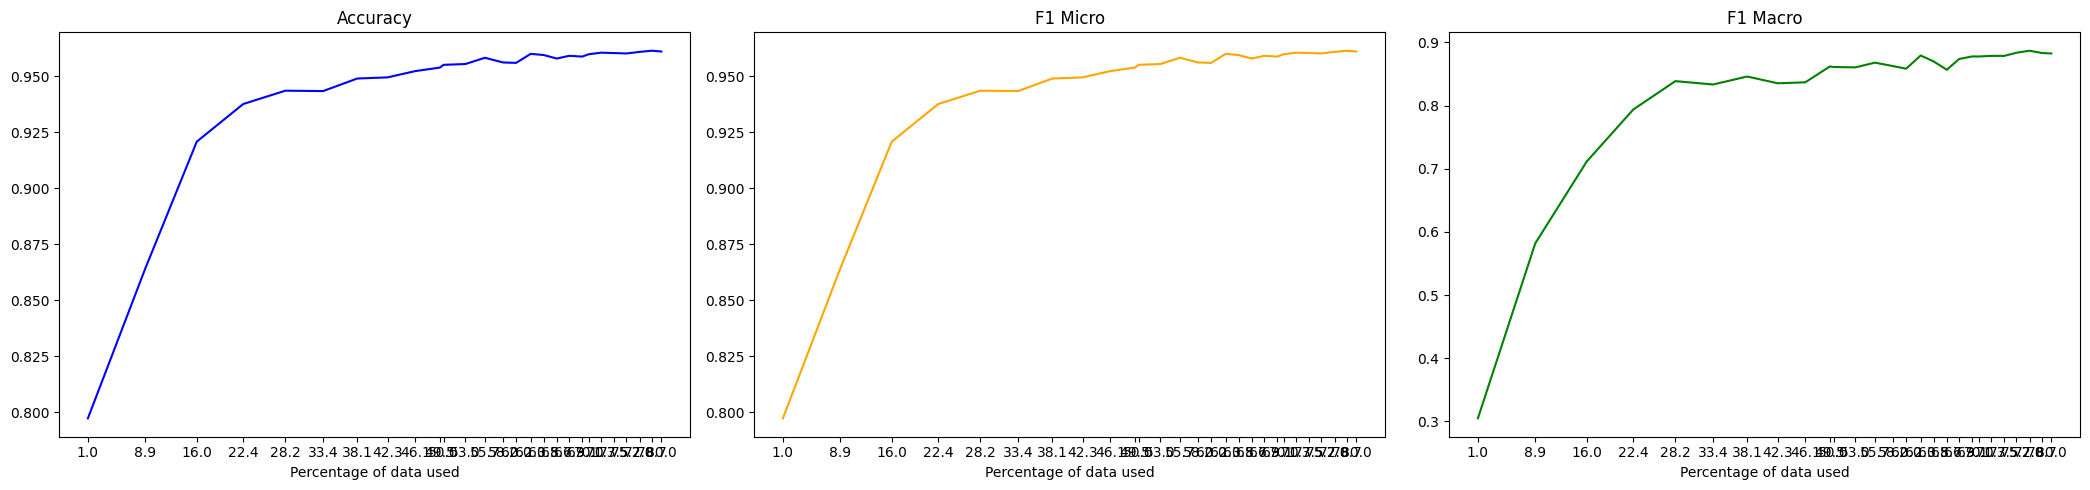

In [21]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6304, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Epoch 2/10, Train Loss: 0.4839, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4257, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4169, Accuracy: 0.8304, F1 Micro: 0.9037, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3785, Accuracy: 0.8505, F1 Micro: 0.9137, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3439, Accuracy: 0.8767, F1 Micro: 0.9277, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8839, F1 Micro: 0.9316, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.274, Accuracy: 0.9042, F1 Micro: 0.9423, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.7088, F1 Micro: 0.7088, F1 Macro: 0.4148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3944, Accuracy: 0.7804, F1 Micro: 0.7804, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3384, Accuracy: 0.7995, F1 Micro: 0.7995, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2906, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.233, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2122, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1913, Accuracy: 0.8222, F1 Micro: 0.8222, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1635, Accuracy: 0.8305, F1 Micro: 0.8305, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.1457, Accuracy: 0.8103, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5713, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4528, Accuracy: 0.8035, F1 Micro: 0.8907, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4318, Accuracy: 0.8205, F1 Micro: 0.8978, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3766, Accuracy: 0.8578, F1 Micro: 0.9171, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.326, Accuracy: 0.8844, F1 Micro: 0.9312, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2775, Accuracy: 0.9135, F1 Micro: 0.9479, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2416, Accuracy: 0.9243, F1 Micro: 0.9541, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2068, Accuracy: 0.9297, F1 Micro: 0.9573, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5428, Accuracy: 0.7429, F1 Micro: 0.7429, F1 Macro: 0.4262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3972, Accuracy: 0.8, F1 Micro: 0.8, F1 Macro: 0.7297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.293, Accuracy: 0.8095, F1 Micro: 0.8095, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.258, Accuracy: 0.8476, F1 Micro: 0.8476, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.8508, F1 Micro: 0.8508, F1 Macro: 0.7808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1535, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.7937
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.8667, F1 Micro: 0.8667, F1 Macro: 0.8009
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.8603, F1 Micro: 0.8603, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.873, F1 Micro: 0.873

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5665, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4788, Accuracy: 0.8108, F1 Micro: 0.8926, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4194, Accuracy: 0.8576, F1 Micro: 0.9174, F1 Macro: 0.9118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3609, Accuracy: 0.9024, F1 Micro: 0.9414, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2864, Accuracy: 0.924, F1 Micro: 0.9537, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2443, Accuracy: 0.9377, F1 Micro: 0.9618, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2217, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1903, Accuracy: 0.9439, F1 Micro: 0.9656, F1 Macro: 0.9631
Epoch 9/10, Train Loss: 0.1609, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4844, Accuracy: 0.8074, F1 Micro: 0.8074, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3211, Accuracy: 0.8512, F1 Micro: 0.8512, F1 Macro: 0.7899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2437, Accuracy: 0.8628, F1 Micro: 0.8628, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.8774, F1 Micro: 0.8774, F1 Macro: 0.8335
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8423
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.8586
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8425
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.892, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.8031, F1 Micro: 0.8904, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4564, Accuracy: 0.8252, F1 Micro: 0.8998, F1 Macro: 0.8913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3705, Accuracy: 0.8896, F1 Micro: 0.9346, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2956, Accuracy: 0.9241, F1 Micro: 0.9538, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.243, Accuracy: 0.9358, F1 Micro: 0.9609, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2074, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.175, Accuracy: 0.9479, F1 Micro: 0.9679, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1514, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4728, Accuracy: 0.8104, F1 Micro: 0.8104, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.8656, F1 Micro: 0.8656, F1 Macro: 0.8174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8442
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8817
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8703
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8749
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8727
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.8052, F1 Micro: 0.8911, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4336, Accuracy: 0.8557, F1 Micro: 0.9162, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3428, Accuracy: 0.9076, F1 Micro: 0.9445, F1 Macro: 0.9407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2646, Accuracy: 0.9337, F1 Micro: 0.9595, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2211, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1828, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.157, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1327, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9693
Epoch 9/10, Train Loss: 0.1138, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8394, F1 Micro: 0.8394, F1 Macro: 0.8003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2511, Accuracy: 0.8584, F1 Micro: 0.8584, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8422
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.8698, F1 Micro: 0.8698, F1 Macro: 0.8385
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1065, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8662
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.885, F1 Micro: 0.885, F1 Macro: 0.8453
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.875
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8675
Epoch 10/10, Train Loss: 0.031, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5139, Accuracy: 0.8068, F1 Micro: 0.8909, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3997, Accuracy: 0.8792, F1 Micro: 0.9285, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2948, Accuracy: 0.9205, F1 Micro: 0.9519, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2325, Accuracy: 0.9373, F1 Micro: 0.9616, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9446, F1 Micro: 0.9662, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9714
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.9575, F1 Micro: 0.9736, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1001, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4283, Accuracy: 0.8274, F1 Micro: 0.8274, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.8771, F1 Micro: 0.8771, F1 Macro: 0.8416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.8856, F1 Micro: 0.8856, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.124, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8679
Epoch 5/10, Train Loss: 0.1024, Accuracy: 0.8856, F1 Micro: 0.8856, F1 Macro: 0.848
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0597, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8727
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8636
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8768
Epoch 10/10, Train Loss: 0.0201, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.507, Accuracy: 0.8087, F1 Micro: 0.8926, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3877, Accuracy: 0.8932, F1 Micro: 0.936, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2805, Accuracy: 0.9238, F1 Micro: 0.9539, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2191, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1796, Accuracy: 0.9396, F1 Micro: 0.9632, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.9453, F1 Micro: 0.9666, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9571, F1 Micro: 0.9734, F1 Macro: 0.971
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0942, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8421, F1 Micro: 0.8421, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.8707, F1 Micro: 0.8707, F1 Macro: 0.8256
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.8489
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.8883, F1 Micro: 0.8883, F1 Macro: 0.8524
Epoch 5/10, Train Loss: 0.0876, Accuracy: 0.8809, F1 Micro: 0.8809, F1 Macro: 0.8374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0645, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8611
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8664
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8566
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5102, Accuracy: 0.8102, F1 Micro: 0.892, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3836, Accuracy: 0.8988, F1 Micro: 0.9399, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.9337, F1 Micro: 0.9596, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.205, Accuracy: 0.9424, F1 Micro: 0.9647, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1406, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9712
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9563, F1 Micro: 0.9731, F1 Macro: 0.9708
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4066, Accuracy: 0.837, F1 Micro: 0.837, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.8806, F1 Micro: 0.8806, F1 Macro: 0.8478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1579, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.119, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0789, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8856
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0445, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8877
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8949
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4969, Accuracy: 0.8139, F1 Micro: 0.8932, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3542, Accuracy: 0.9068, F1 Micro: 0.9439, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2486, Accuracy: 0.9319, F1 Micro: 0.9585, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9571, F1 Micro: 0.9734, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0967, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8536, F1 Micro: 0.8536, F1 Macro: 0.8067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1217, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0998, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8702
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8723
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8705
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5057, Accuracy: 0.8116, F1 Micro: 0.894, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3575, Accuracy: 0.9125, F1 Micro: 0.9472, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2529, Accuracy: 0.938, F1 Micro: 0.9619, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9467, F1 Micro: 0.9672, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8454, F1 Micro: 0.8454, F1 Macro: 0.8067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.8722, F1 Micro: 0.8722, F1 Macro: 0.8337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1569, Accuracy: 0.8954, F1 Micro: 0.8954, F1 Macro: 0.8652
Epoch 4/10, Train Loss: 0.1079, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0901, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8758
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8814
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4946, Accuracy: 0.8135, F1 Micro: 0.8946, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3511, Accuracy: 0.9135, F1 Micro: 0.9478, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.9391, F1 Micro: 0.9628, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0799, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1104, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0947, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8787
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8553
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8829
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8756
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8782
Epoch 10/10, Train Loss: 0.0379, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4896, Accuracy: 0.8222, F1 Micro: 0.8997, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3392, Accuracy: 0.922, F1 Micro: 0.9527, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2367, Accuracy: 0.9424, F1 Micro: 0.9647, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0803, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2286, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.8582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1496, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1063, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.0851, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8815
Epoch 6/10, Train Loss: 0.0625, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8828
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8743
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8757
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.903, F1 Micro: 0.903, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4899, Accuracy: 0.8307, F1 Micro: 0.9038, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3318, Accuracy: 0.9226, F1 Micro: 0.9528, F1 Macro: 0.9484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2346, Accuracy: 0.9427, F1 Micro: 0.9648, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9719
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1493, Accuracy: 0.9169, F1 Micro: 0.9169, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1066, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0843, Accuracy: 0.9207, F1 Micro: 0.9207, F1 Macro: 0.898
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8826
Epoch 7/10, Train Loss: 0.0516, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.892
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8948
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8967
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.916, F1 Micro: 0.916, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4875, Accuracy: 0.8321, F1 Micro: 0.9043, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.318, Accuracy: 0.9253, F1 Micro: 0.9547, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.8293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2341, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1123, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0835, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8933
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.881
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8757
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4795, Accuracy: 0.8498, F1 Micro: 0.9125, F1 Macro: 0.9047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.321, Accuracy: 0.9224, F1 Micro: 0.9533, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9595, F1 Micro: 0.9751, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.8165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2265, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1159, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0825, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0692, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8918
Epoch 7/10, Train Loss: 0.0438, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8928
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8842
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4817, Accuracy: 0.8481, F1 Micro: 0.9122, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3186, Accuracy: 0.9262, F1 Micro: 0.9553, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9698
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.86, F1 Micro: 0.86, F1 Macro: 0.815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1292, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.877
Epoch 5/10, Train Loss: 0.0851, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8776
Epoch 6/10, Train Loss: 0.0677, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8715
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8617
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8801
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9097

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4849, Accuracy: 0.8415, F1 Micro: 0.9093, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3135, Accuracy: 0.9325, F1 Micro: 0.9589, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9604, F1 Micro: 0.9756, F1 Macro: 0.9734
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9724
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.973
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8391, F1 Micro: 0.8391, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1056, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8836
Epoch 5/10, Train Loss: 0.087, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8794
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0428, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8941
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.8568, F1 Micro: 0.9164, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3096, Accuracy: 0.9267, F1 Micro: 0.9556, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9434, F1 Micro: 0.9655, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9703
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9642, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3595, Accuracy: 0.8825, F1 Micro: 0.8825, F1 Macro: 0.8466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1483, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0978, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0905, Accuracy: 0.9229, F1 Micro: 0.9229, F1 Macro: 0.8999
Epoch 6/10, Train Loss: 0.0659, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.8937
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8889
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8897
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8855
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9211, F1 Micro: 0.9211, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.473, Accuracy: 0.8613, F1 Micro: 0.9192, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2948, Accuracy: 0.9332, F1 Micro: 0.9592, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3568, Accuracy: 0.8516, F1 Micro: 0.8516, F1 Macro: 0.7887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2042, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1514, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8946
Epoch 4/10, Train Loss: 0.1066, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8892
Epoch 5/10, Train Loss: 0.0826, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8837
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8953
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8837
Epoch 10/10, Train Loss: 0.0269, Accuracy: 0.918, F1 Micro: 0.918, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.871, F1 Micro: 0.9241, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2996, Accuracy: 0.9306, F1 Micro: 0.958, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2046, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1508, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1115, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8842
Epoch 5/10, Train Loss: 0.0767, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8774
Epoch 6/10, Train Loss: 0.0674, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8709
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8779
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.878
Epoch 9/10, Train Loss: 0.0237, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8724
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8816

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8734, F1 Micro: 0.926, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.9356, F1 Micro: 0.9608, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.8344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2076, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1143, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0784, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8901
Epoch 6/10, Train Loss: 0.0661, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0387, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.893
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8819
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8893
Epoch 10/10, Train Loss: 0.0163, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8793, F1 Micro: 0.9289, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2848, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3497, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.8066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.109, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8922
Epoch 5/10, Train Loss: 0.0981, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0664, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8915
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9207, F1 Micro: 0.9207, F1 Macro: 0.8937
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.877
Epoch 10/10, Train Loss: 0.0309, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4634, Accuracy: 0.8816, F1 Micro: 0.9304, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2744, Accuracy: 0.937, F1 Micro: 0.9616, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1956, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1162, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8886
Epoch 5/10, Train Loss: 0.072, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8887
Epoch 6/10, Train Loss: 0.0544, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8898
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4622, Accuracy: 0.88, F1 Micro: 0.9291, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.9352, F1 Micro: 0.9607, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3272, Accuracy: 0.8712, F1 Micro: 0.8712, F1 Macro: 0.8322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2024, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1309, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0928, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8892
Epoch 5/10, Train Loss: 0.063, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.883
Epoch 6/10, Train Loss: 0.0664, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8766
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9169, F1 Micro: 0.9169, F1 Macro: 0.8929
Epoch 9/10, Train Loss: 0.0227, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8878
Epoch 10/10, Train Loss: 0.0193, Accuracy: 0.9078, F1 Micro: 0.9078, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4481, Accuracy: 0.8861, F1 Micro: 0.932, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.9408, F1 Micro: 0.9638, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9642, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3505, Accuracy: 0.8805, F1 Micro: 0.8805, F1 Macro: 0.8433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1374, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1006, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0725, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0536, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9017
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8855
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.921, F1 Micro: 0.921, F1 Macro: 0.8975
Epoch 9/10, Train Loss: 0.0189, Accuracy: 0.921, F1 Micro: 0.921, F1 Macro: 0.8957
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4495, Accuracy: 0.8797, F1 Micro: 0.9292, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.9398, F1 Micro: 0.9633, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.35, Accuracy: 0.8777, F1 Micro: 0.8777, F1 Macro: 0.8423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2003, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1301, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8882
Epoch 4/10, Train Loss: 0.0885, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8876
Epoch 5/10, Train Loss: 0.0699, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8783
Epoch 6/10, Train Loss: 0.0613, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0405, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8899
Epoch 8/10, Train Loss: 0.0307, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8903
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8851
Epoch 10/10, Train Loss: 0.018, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.886

Sentiment analysis acc

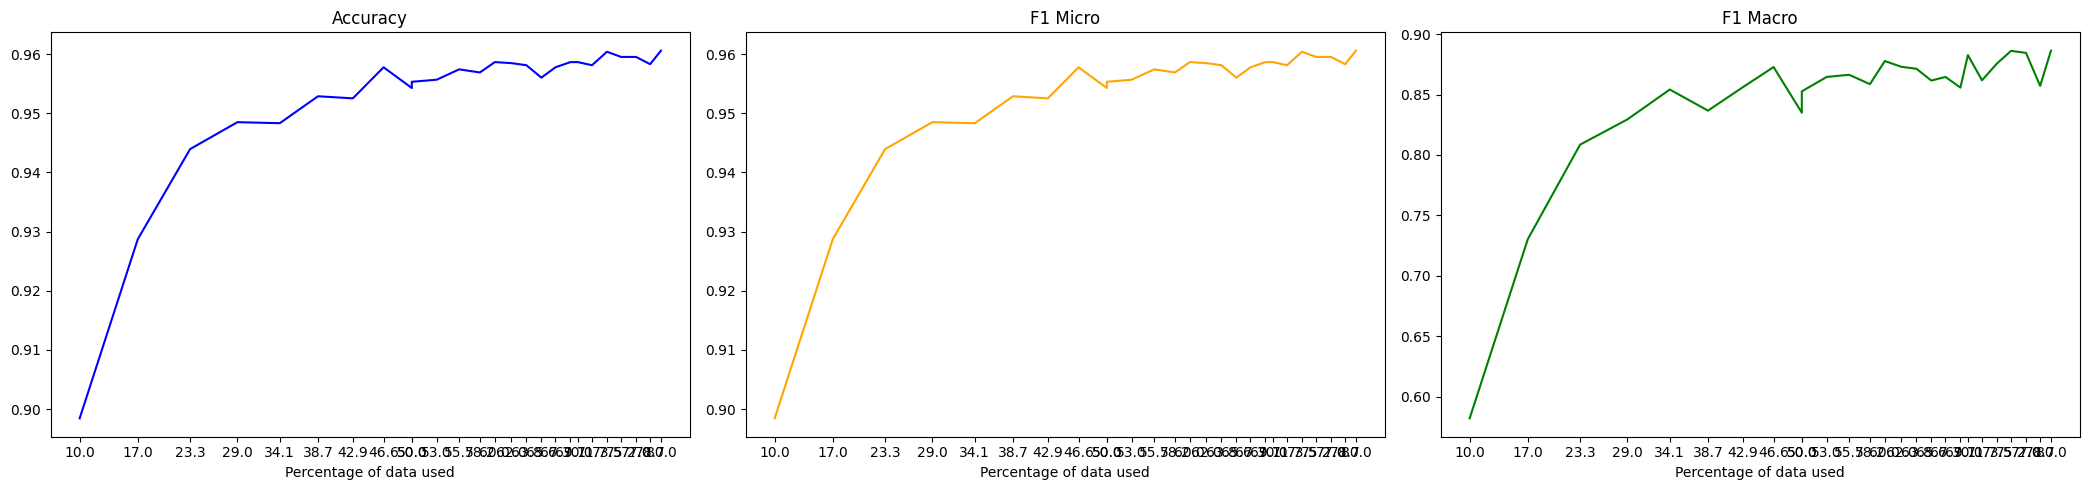

In [22]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)